In [1]:
library(igraph)
library("data.table")
library(plyr)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [2]:
data<-fread("Data/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv", header=TRUE, sep=",",stringsAsFactors=FALSE)

In [3]:
location<-fread("Data/location.csv", header=TRUE, sep=",",stringsAsFactors=FALSE)
coordinates<-fread("Data/coordinates.txt", header=FALSE, sep="\t",stringsAsFactors=FALSE)

In [4]:
data_needed=data.frame(data$sourceid,data$dstid,data$month,data$mean_travel_time)
data_needed= subset(data_needed, data.month == "12")
data_needed=data.frame(data_needed$data.sourceid,data_needed$data.dstid,data_needed$data.mean_travel_time)


In [5]:
colnames(data_needed) <- c("sourceid", "dstid","weight")

In [6]:
g<-graph_from_data_frame(data_needed, directed=FALSE)
is_weighted(g)

[1] TRUE

In [7]:
arr = c()

for(i in 1: length(V(g)))
{   arr[i]=location$properties.DISPLAY_NAME[location$properties.MOVEMENT_ID==get.vertex.attribute(g, "name",i)]
     vec=c()
    vec[1]=coordinates$V2[coordinates$V1==get.vertex.attribute(g, "name",i)]
    vec[2]=coordinates$V3[coordinates$V1==get.vertex.attribute(g, "name",i)]
    g <- set.vertex.attribute(g, 'coordinates', i, list(vec))
}



In [8]:
g<-set_vertex_attr(g, 'location', index = V(g), arr)


In [9]:
gcc<-induced.subgraph(g, which(clusters(g)$membership == which.max(clusters(g)$csize)))

In [10]:
gcc<-simplify(gcc, edge.attr.comb="mean",remove.multiple=TRUE)

### Question 6

In [11]:
ecount(gcc)
vcount(gcc)

[1] 311802

[1] 1880

### Question 7


In [12]:
tree<-mst(gcc)
E(tree)[1]


+ 1/1879 edge from 61c09ed (vertex names):
[1] 1938--1241

In [13]:
which(V(tree)$name == "1938")
which(V(tree)$name == "1241")

[1] 1

[1] 523

In [14]:
get.vertex.attribute(tree,"location",1)
get.vertex.attribute(tree,"location",523)

[1] "3300 Brodie Drive, South San Jose, San Jose"

[1] "4300 La Torre Avenue, South San Jose, San Jose"

In [15]:
E(tree)[[3]]

+ 1/1879 edge from 61c09ed (vertex names):
  tail head tid  hid  weight
3 1938 2631   1 1286 109.625

In [16]:
which(V(tree)$name == "1938")
which(V(tree)$name == "2631")

[1] 1

[1] 1286

In [17]:
get.vertex.attribute(tree,"location",1)
get.vertex.attribute(tree,"location",1286)

[1] "3300 Brodie Drive, South San Jose, San Jose"

[1] "400 Ginkgo Court, South San Jose, San Jose"

In [18]:
E(tree)[4]

+ 1/1879 edge from 61c09ed (vertex names):
[1] 1747--1455

In [19]:
which(V(tree)$name == "1747")
which(V(tree)$name == "1455")

[1] 2

[1] 104

In [20]:
get.vertex.attribute(tree,"location",2)
get.vertex.attribute(tree,"location",104)

[1] "1700 Coyote Point Drive, Shoreview, San Mateo"

[1] "1800 Helene Court, East San Mateo, San Mateo"

### Question 8

In [21]:

list_triangles<-triangles(gcc)
list_triangles<-as.vector(list_triangles)
length(list_triangles)/3

[1] 31678905

In [22]:
i=1
c = 0
sum=0
while(c < 1000)
{   i=sample(1:31678904, 1)
    i=i*3
    v1=list_triangles[[i+1]]
    v2=list_triangles[[i+2]]
    v3=list_triangles[[i+3]]
    e1=get.edge.ids(gcc,c(v1,v2))
    e2=get.edge.ids(gcc,c(v2,v3))
    e3=get.edge.ids(gcc,c(v1,v3))
    w1=get.edge.attribute(gcc,"weight",e1)
    w2=get.edge.attribute(gcc,"weight",e2)
    w3=get.edge.attribute(gcc,"weight",e3)
    if((w1<(w2+w3))&&(w2<(w1+w3))&&(w3<(w1+w2)))
    {
     sum=sum+1   
    }
    i=i+3
    c=c+1
}

In [23]:
sum

[1] 934

In [24]:
(sum)/c

[1] 0.934

### Question 9

In [25]:
 
dfs_res<-dfs(tree,root=1,neimode=c("total"))
preorder<-dfs_res$order
preorder_ids=as.vector(preorder)
preorder_ids=c(preorder_ids,1)

In [28]:

actual_path=c()
actual_path=c(actual_path,preorder_ids[1])
approx_wht=0

for (i in 1:(length(preorder_ids)-1))
{
    wht = get.edge.attribute(gcc,"weight",get.edge.ids(gcc,c(preorder_ids[i],preorder_ids[i+1])))
    
    if(length(wht)!=0 && wht!=0)
    {
        actual_path= c(actual_path,preorder_ids[i+1])
        approx_wht = approx_wht + wht
        
    }
    else
    {
        sp<-get.shortest.paths(gcc, preorder_ids[i], to=preorder_ids[i+1], mode = c("all"))$vpath
        sp<-as.vector(sp[[1]])
        actual_path=c(actual_path,sp[2:length(sp)])
        for(j in 1: (length(sp)-1))
        {
            wht = get.edge.attribute(gcc,"weight",get.edge.ids(gcc,c(sp[j],sp[j+1])))
            approx_wht = approx_wht + wht
        }
      
    }

}

In [29]:

optim=0
for(i in 1: length(E(tree)))
{
    optim=optim+E(tree)[i]$weight

}
optim

[1] 279408.2

In [30]:
approx_wht/optim

[1] 1.663367

In [31]:
x_ax=c()
y_ax=c()
for(i in 1:length(actual_path))
{

    x_ax=c(x_ax,V(gcc)[actual_path[i]]$coordinates[[1]][1])
    y_ax=c(y_ax,V(gcc)[actual_path[i]]$coordinates[[1]][2])
}

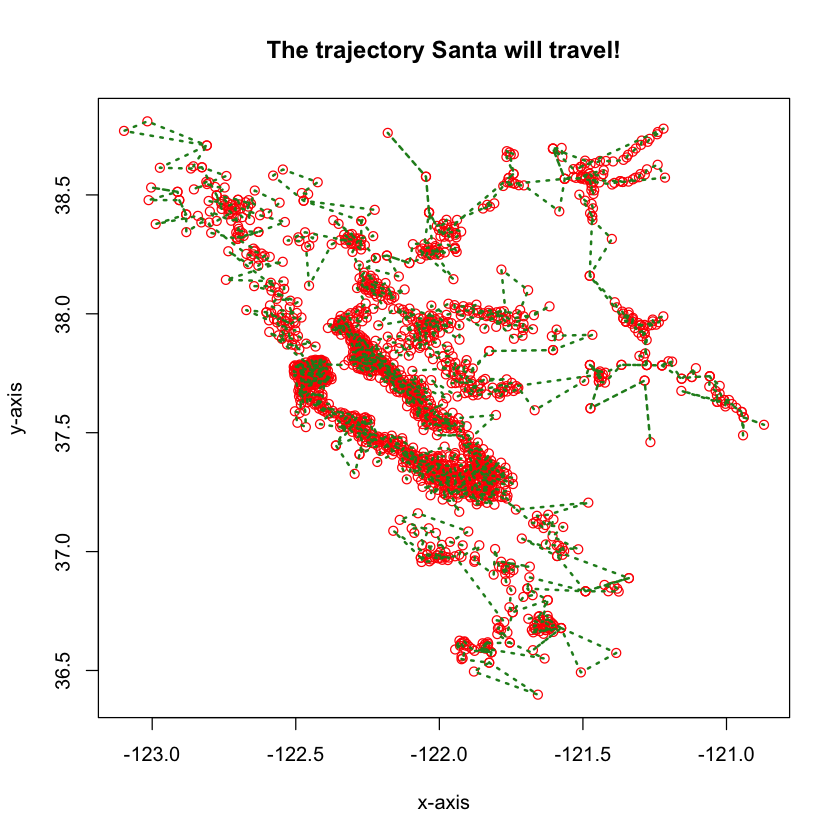

In [32]:
#heading = "The trajectory Santa will travel!"
plot(x_ax,y_ax,main="The trajectory Santa will travel!",xlab="x-axis",ylab="y-axis", col = "red")
lines(x_ax,y_ax,type="l", lty=3, lwd=2, col="forestgreen")